# Data Quality — Stable Key Coverage

**Purpose:** Verify the quality of the stable cross-optimization function identity
key. This notebook answers: *"How well can we track functions across optimization
levels?"*

The stable key is `(test_case, decl_file, decl_line, decl_column,
dwarf_function_name_norm)` built from DWARF `DW_AT_decl_file` /
`DW_AT_decl_line` / `DW_AT_decl_column` attributes. Three quality tiers:

- **HIGH** — full key including column; maximal precision.
- **MEDIUM** — file + line present but column missing. Cross-opt matching
  works but rare collisions are possible for macro-generated functions on
  the same line.
- **UNRESOLVED** — file or line missing; function cannot be matched across
  optimization levels.

Set `OPT_A` and `OPT_B` in the load cell to select which optimization pair
to analyse.

1. **Key quality distribution** — stacked bar per test case.
2. **Dropped / unresolved function table** — which functions have issues.

In [1]:
## ── Imports & Style ──────────────────────────────────────────────────────────

from pathlib import Path
import sys, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, str(Path("../..").resolve()))

from data import (
    load_dataset, enrich_pairs, compute_transitions,
    AlignmentVerdict,
)
from data.enums import StableKeyQuality

warnings.filterwarnings("ignore", category=FutureWarning)

QUALITY_COLORS = {
    StableKeyQuality.HIGH.value:       "#66c2a5",
    StableKeyQuality.MEDIUM.value:     "#fc8d62",
    StableKeyQuality.LOW.value:        "#e78ac3",
    StableKeyQuality.UNRESOLVED.value: "#8da0cb",
}

THESIS_RC = {
    "font.family": "serif", "font.size": 10,
    "axes.titlesize": 12, "axes.labelsize": 10,
    "xtick.labelsize": 9, "ytick.labelsize": 9,
    "legend.fontsize": 9, "figure.dpi": 120,
    "savefig.dpi": 300, "savefig.bbox": "tight",
    "figure.figsize": (7, 4.5),
    "axes.spines.top": False, "axes.spines.right": False,
}
plt.rcParams.update(THESIS_RC)
sns.set_context("paper", rc=THESIS_RC)

FIG_DIR = Path("../../figures/oracle_analysis")
FIG_DIR.mkdir(parents=True, exist_ok=True)

def save_fig(name: str, fig=None):
    fig = fig or plt.gcf()
    for ext in ("pdf", "png"):
        fig.savefig(FIG_DIR / f"{name}.{ext}", bbox_inches="tight")
    print(f"  → saved {FIG_DIR / name}.{{pdf,png}}")

print("✓ imports & style ready")

✓ imports & style ready


In [9]:
## ── Load Data & Compute Transitions ─────────────────────────────────────────

SELECTED_TESTS: list[str] | None = None
OPT_LEVELS = ["O0", "O1", "O2", "O3"]
VARIANT = "debug"

# ── Choose which two levels to compare ───────────────────────────────────────
OPT_A = "O0"   # baseline
OPT_B = "O3"   # comparison target

ds = load_dataset(
    Path("../../docker/local-files/artifacts/synthetic"),
    test_cases=SELECTED_TESTS,
    opt_levels=OPT_LEVELS,
    variant=VARIANT,
)

df_pairs = enrich_pairs(ds.pairs)
tests    = ds.test_cases

df_trans = compute_transitions(
    df_pairs, ds.non_targets,
    opt_a=OPT_A, opt_b=OPT_B,
)

n_high = (df_trans["key_quality"] == StableKeyQuality.HIGH.value).sum()
n_medium = (df_trans["key_quality"] == StableKeyQuality.MEDIUM.value).sum()
n_unresolved = (df_trans["key_quality"] == StableKeyQuality.UNRESOLVED.value).sum()

print(f"✓ {len(df_trans)} transition rows across {len(tests)} test cases ({OPT_A} → {OPT_B})")
print(f"  {n_high} HIGH, {n_medium} MEDIUM, {n_unresolved} UNRESOLVED")

✓ 471 transition rows across 12 test cases (O0 → O3)
  415 HIGH, 35 MEDIUM, 21 UNRESOLVED


---
## Plot 1 — Stable Key Quality Distribution

**What it shows:** For each test case, how many functions fall into each
key quality tier (HIGH / MEDIUM / UNRESOLVED).

**Function used:** `compute_transitions()` → `key_quality` column

**How it's computed:**

- **HIGH:** The function has `decl_file`, `decl_line`, *and* `decl_column`
  from DWARF metadata. The full stable key
  `(test_case, decl_file, decl_line, decl_column, name)` provides maximal
  cross-opt matching precision.

- **MEDIUM:** The function has `decl_file` and `decl_line` but is missing
  `decl_column`. Cross-opt matching still works but two functions declared
  on the same source line (e.g., macro-generated statics) could theoretically
  collide. This tier is expected when compilers omit `DW_AT_decl_column`.

- **UNRESOLVED:** The function is missing `decl_file` or `decl_line`. This
  happens when the compiler doesn't emit `DW_AT_decl_file` for a subprogram
  (e.g., compiler-generated functions, some builtins). These functions *cannot*
  be matched across optimization levels, so they appear as one-sided rows
  in the transition table.

**Why it matters:** UNRESOLVED functions are a data quality limitation —
they inflate the "ABSENT" category in transition matrices and can't be
tracked for fragility analysis.

  → saved ..\..\figures\oracle_analysis\11_key_quality_distribution.{pdf,png}


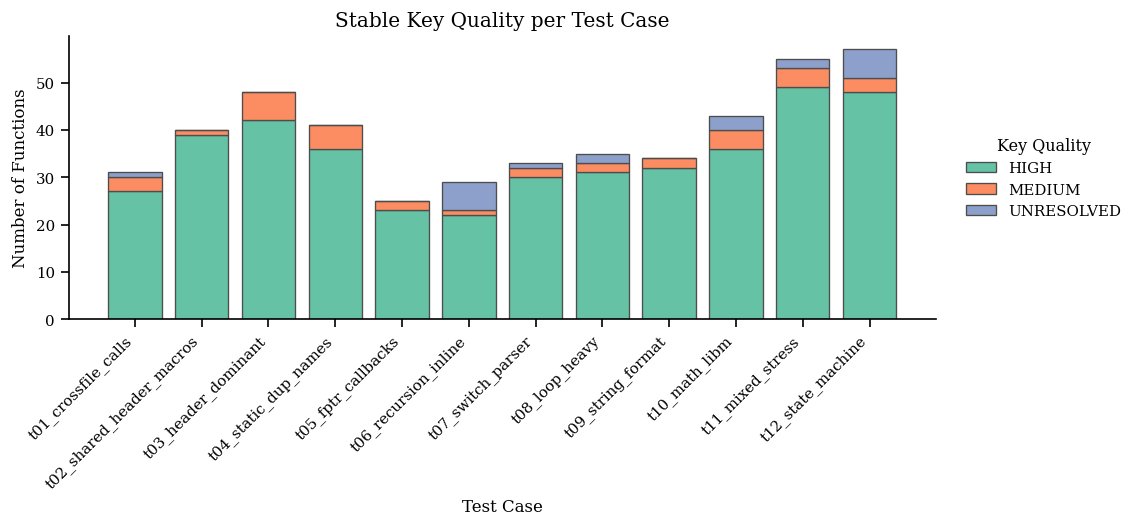

  HIGH: 415 functions (88.1%)
  MEDIUM: 35 functions (7.4%)
  UNRESOLVED: 21 functions (4.5%)


In [10]:
## ── Plot 1: Key Quality Stacked Bar per Test Case ────────────────────────────

quality_counts = (
    df_trans.groupby(["test_case", "key_quality"])
    .size()
    .unstack(fill_value=0)
)

# Reorder columns to match enum order
q_order = [q.value for q in StableKeyQuality if q.value in quality_counts.columns]
quality_counts = quality_counts[q_order]

fig, ax = plt.subplots(figsize=(max(7, len(tests) * 0.8), 4.5))

bottom = np.zeros(len(quality_counts))
for q in q_order:
    vals = quality_counts[q].values
    ax.bar(quality_counts.index, vals, bottom=bottom, #type: ignore
           label=q, color=QUALITY_COLORS.get(q, "#999999"), edgecolor="0.3")
    bottom += vals #type: ignore

ax.set_xlabel("Test Case")
ax.set_ylabel("Number of Functions")
ax.set_title("Stable Key Quality per Test Case")
ax.legend(title="Key Quality", frameon=False,
          loc="center left", bbox_to_anchor=(1.02, 0.5))
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

save_fig("11_key_quality_distribution")
plt.show()

# Summary stats
for q in q_order:
    total = quality_counts[q].sum()
    pct = total / len(df_trans) * 100
    print(f"  {q}: {total} functions ({pct:.1f}%)")

---
## Table — Dropped & Unresolved Functions

Lists specific functions that are either:
- **Dropped:** Present and targetable at OPT_A but lost (NON_TARGET or ABSENT)
  at OPT_B.
- **Unresolved:** Missing source declaration info, so they can't be tracked
  across optimization levels.

In [11]:
## ── Table: Dropped Functions ─────────────────────────────────────────────────

df_dropped = df_trans[df_trans["dropped"]].copy()

if df_dropped.empty:
    print(f"✓ No dropped functions ({OPT_A} → {OPT_B})")
else:
    drop_cols = [
        "test_case", "dwarf_function_name",
        "decl_file", "decl_line",
        f"verdict_{OPT_A}", f"verdict_{OPT_B}",
        f"overlap_{OPT_A}", "key_quality",
    ]
    drop_cols = [c for c in drop_cols if c in df_dropped.columns]
    display(
        df_dropped[drop_cols]
        .style.set_caption(f"Dropped Functions: targetable at {OPT_A}, lost at {OPT_B}")
    )

print()

## ── Table: Unresolved Functions ──────────────────────────────────────────────

df_unresolved = df_trans[
    df_trans["key_quality"] == StableKeyQuality.UNRESOLVED.value
].copy()

if df_unresolved.empty:
    print("✓ No unresolved functions")
else:
    unres_cols = [
        "test_case", "dwarf_function_name",
        f"verdict_{OPT_A}", f"verdict_{OPT_B}",
        "key_quality",
    ]
    unres_cols = [c for c in unres_cols if c in df_unresolved.columns]
    display(
        df_unresolved[unres_cols]
        .style.set_caption("Unresolved Functions: missing decl_file/decl_line")
    )

,test_case,dwarf_function_name,decl_file,decl_line,verdict_O0,verdict_O3,overlap_O0,key_quality
27,t01_crossfile_calls,array_range,/tmp/reforge_builds/t01_crossfile_calls/src/arrays.c,41.000000,MATCH,ABSENT,1.000000,HIGH
29,t01_crossfile_calls,clamp_int,/tmp/reforge_builds/t01_crossfile_calls/src/common.h,15.000000,AMBIGUOUS,NON_TARGET,1.000000,HIGH
30,t01_crossfile_calls,clamp_int,/tmp/reforge_builds/t01_crossfile_calls/src/common.h,15.000000,AMBIGUOUS,NON_TARGET,1.000000,HIGH
31,t01_crossfile_calls,clamp_int,/tmp/reforge_builds/t01_crossfile_calls/src/common.h,15.000000,AMBIGUOUS,NON_TARGET,1.000000,HIGH
32,t01_crossfile_calls,clamp_int,/tmp/reforge_builds/t01_crossfile_calls/src/common.h,15.000000,AMBIGUOUS,NON_TARGET,1.000000,HIGH
45,t01_crossfile_calls,string_is_alpha,/tmp/reforge_builds/t01_crossfile_calls/src/strings.c,42.000000,MATCH,ABSENT,1.000000,HIGH
46,t01_crossfile_calls,string_length,/tmp/reforge_builds/t01_crossfile_calls/src/strings.c,5.000000,MATCH,NON_TARGET,1.000000,HIGH
52,t02_shared_header_macros,lcm,/tmp/reforge_builds/t02_shared_header_macros/src/arith.c,16.000000,MATCH,NON_TARGET,1.000000,HIGH
53,t02_shared_header_macros,sum_of_squares,/tmp/reforge_builds/t02_shared_header_macros/src/arith.c,21.000000,MATCH,NON_TARGET,1.000000,HIGH
55,t02_shared_header_macros,gcd,/tmp/reforge_builds/t02_shared_header_macros/src/arith.c,5.000000,MATCH,NON_TARGET,1.000000,HIGH


,test_case,dwarf_function_name,verdict_O0,verdict_O3,key_quality
0,t12_state_machine,nan,ABSENT,MATCH,UNRESOLVED
1,t12_state_machine,nan,ABSENT,MATCH,UNRESOLVED
2,t12_state_machine,nan,ABSENT,MATCH,UNRESOLVED
3,t12_state_machine,nan,ABSENT,MATCH,UNRESOLVED
4,t06_recursion_inline,nan,ABSENT,MATCH,UNRESOLVED
5,t06_recursion_inline,nan,ABSENT,MATCH,UNRESOLVED
6,t06_recursion_inline,nan,ABSENT,NO_MATCH,UNRESOLVED
7,t01_crossfile_calls,nan,ABSENT,MATCH,UNRESOLVED
8,t11_mixed_stress,nan,ABSENT,MATCH,UNRESOLVED
9,t11_mixed_stress,nan,ABSENT,MATCH,UNRESOLVED
